In [35]:
from kipoi_cadd.data import cadd_train_valid_data, train_test_split_indexes, CaddDataset
from kipoi_cadd.utils import dump_to_pickle, load_pickle
import pandas as pd
import time
from tqdm import tqdm, trange
import numpy as np
from kipoi.data_utils import numpy_collate_concat
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [36]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/"
lmdb_dir = training_dir + "lmdb"
valid_id_file = training_dir + "valid_idx.pkl"
all_ids_file = training_dir + "variant_ids.pkl"
ids_10k_file = training_dir + "sample_indices/ids_10k.pkl"

In [34]:
np.finfo(np.float16).max

65500.0

In [24]:
def load_n_batch(ds, num_workers=1, shuffle=False, drop_last=False):
    D = len(ds.__getitem__(0)['inputs'])
    N = ds.__len__()
    X = np.zeros((N, D), dtype=np.float16)
    y = np.zeros(N, dtype=np.float16)

    it = ds.batch_iter(batch_size=N, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)
    item = next(it)
    return item['inputs'], item['targets']

def load_n_single(ds, shuffle=False):
    D = len(ds.__getitem__(0)['inputs'])
    N = ds.__len__()
    X = np.zeros((N, D), dtype=np.float16)
    y = np.zeros(N, dtype=np.float16)

    for idx in trange(N):
        item = ds.__getitem__(idx)
        X[idx,:] = item['inputs']
        y[idx] = item['targets']
    return X, y

def load_n_batch_loop(ds, num_workers=1, batch_size=64, shuffle=False):
    D = len(ds.__getitem__(0)['inputs'])
    N = ds.__len__()
    X = np.zeros((N, D), dtype=np.float16)
    y = np.zeros(N, dtype=np.float16)
    
    # Batch iter does not loop infinetly. When the ds will end, the last batch's size, will be that
    # of the number of remaining samples
    it = ds.batch_iter(batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    i = 0
    for sample in tqdm(it):
        bs = sample['inputs'].shape[0]
        X[i:i+bs,:] = sample['inputs']
        y[i:i+bs] = sample['targets']
        i = i + bs
    return X, y

def load_n_collate(ds, num_workers=1, batch_size=64, shuffle=False, drop_last=True):
    it = ds.batch_iter(batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, drop_last=drop_last)
    return numpy_collate_concat([x for x in tqdm(it)])

In [25]:
%%time
times_n_batch = {'bs': [], 'time': [], 'pos': []}
for s in ["10k", "50k", "100k", "500k", "1M"]:
    filename = training_dir + "sample_indices/sample" + s + ".pkl"
    num_workers = 10
    if s == "500k" or s == "1M":
        start = end = 0
        X = y = np.array([0])
    else:
        ds = CaddDataset(lmdb_dir, filename)
        start = time.time()
        X, y = load_n_batch(ds, num_workers=num_workers, shuffle=False)
        end = time.time()

    times_n_batch['bs'].append(ds.__len__())
    times_n_batch['time'].append(end-start)
    times_n_batch['pos'].append(sum(y))
    
    print(sum(y), X.shape, end-start, num_workers)

5071.0 (10000, 1063) 6.983842372894287 10
24827.0 (50000, 1063) 16.2116961479187 10
50079.0 (100000, 1063) 34.42905831336975 10
0 (1,) 0 10
0 (1,) 0 10
CPU times: user 763 ms, sys: 10.8 s, total: 11.5 s
Wall time: 57.9 s


In [26]:
%%time
times_n_single = {'bs': [], 'time': [], 'pos': []}
for s in ["10k", "50k", "100k", "500k", "1M"]:
    filename = training_dir + "sample_indices/sample" + s + ".pkl"
    ds = CaddDataset(lmdb_dir, filename)
    
    start = time.time()
    X, y = load_n_single(ds, shuffle=False)
    end = time.time()
    times_n_single['bs'].append(ds.__len__())
    times_n_single['time'].append(end-start)
    times_n_single['pos'].append(sum(y))
    
    print(sum(y), X.shape, end-start, num_workers)

  0%|          | 0/50000 [00:00<?, ?it/s]

5071.0 (10000, 1063) 1.8878169059753418 10


100%|██████████| 50000/50000 [00:09<00:00, 5534.69it/s]


24827.0 (50000, 1063) 9.167554378509521 10


100%|██████████| 100000/100000 [00:17<00:00, 5571.49it/s]


50079.0 (100000, 1063) 18.19524359703064 10


100%|██████████| 500000/500000 [01:25<00:00, 5853.96it/s]


249625.0 (500000, 1063) 86.34629440307617 10


100%|██████████| 1000000/1000000 [02:43<00:00, 6106.01it/s]


499784.0 (1000000, 1063) 163.77932715415955 10
CPU times: user 4min 16s, sys: 26.9 s, total: 4min 43s
Wall time: 4min 42s


In [27]:
%%time
times_n_collate = {'bs': [], 'time': [], 'pos': []}
for s in ["10k", "50k", "100k", "500k", "1M"]:
    filename = training_dir + "sample_indices/sample" + s + ".pkl"
    ds = CaddDataset(lmdb_dir, filename)
    
    start = time.time()
    items = load_n_collate(ds, batch_size=64, num_workers=10, shuffle=False, drop_last=False)
    end = time.time()
    times_n_collate['bs'].append(ds.__len__())
    times_n_collate['time'].append(end-start)
    times_n_collate['pos'].append(sum(items['targets']))

    print(sum(items['targets']), items['inputs'].shape, end-start)

100%|██████████| 157/157 [00:00<00:00, 200.54it/s]


5071.0 (10000, 1063) 4.025237798690796


100%|██████████| 782/782 [00:01<00:00, 494.21it/s]

24827.0 (50000, 1063) 2.7535035610198975



100%|██████████| 1563/1563 [00:03<00:00, 449.30it/s]


50079.0 (100000, 1063) 5.628856658935547


100%|██████████| 7813/7813 [00:14<00:00, 552.92it/s]


249625.0 (500000, 1063) 21.753267288208008


100%|██████████| 15625/15625 [00:27<00:00, 574.41it/s]


499784.0 (1000000, 1063) 41.00003981590271
CPU times: user 23.6 s, sys: 29.5 s, total: 53.2 s
Wall time: 1min 17s


In [28]:
%%time
times_n_batch_loop = {'bs': [], 'time': [], 'pos': []}
for s in ["10k", "50k", "100k", "500k", "1M"]:
    filename = training_dir + "sample_indices/sample" + s + ".pkl"
    ds = CaddDataset(lmdb_dir, filename)
    start = time.time()
    X, y = load_n_batch_loop(ds, num_workers=10, batch_size=64, shuffle=False)
    end = time.time()
    times_n_batch_loop['bs'].append(ds.__len__())
    times_n_batch_loop['time'].append(end-start)
    times_n_batch_loop['pos'].append(sum(y))

    print(sum(y), X.shape, end-start)

100%|██████████| 157/157 [00:00<00:00, 208.25it/s]


5071.0 (10000, 1063) 3.313337564468384


100%|██████████| 782/782 [00:01<00:00, 469.16it/s]


24827.0 (50000, 1063) 3.341358184814453


100%|██████████| 1563/1563 [00:03<00:00, 487.22it/s]


50079.0 (100000, 1063) 4.969335079193115


100%|██████████| 7813/7813 [00:14<00:00, 552.88it/s]


249625.0 (500000, 1063) 15.849244356155396


100%|██████████| 15625/15625 [00:25<00:00, 616.63it/s]


499784.0 (1000000, 1063) 27.458829641342163
CPU times: user 13.9 s, sys: 18.3 s, total: 32.1 s
Wall time: 56.7 s


## Now we want to plot these speeds
https://python-graph-gallery.com/122-multiple-lines-chart/

In [12]:
import matplotlib.pyplot as plt

In [16]:
print(times_n_collate)
print(times_n_single)

{'bs': [10000, 50000, 100000, 500000, 1000000], 'time': [1.8848204612731934, 9.160690307617188, 18.593568325042725, 83.70752692222595, 167.90151858329773], 'pos': [5071.0, 24827.0, 50079.0, 249625.0, 499784.0]}
{'bs': [10000, 50000, 100000, 500000, 1000000], 'time': [1.8190932273864746, 8.74219822883606, 17.99203085899353, 84.04953575134277, 168.44957613945007], 'pos': [5071.0, 24827.0, 50079.0, 249625.0, 499784.0]}


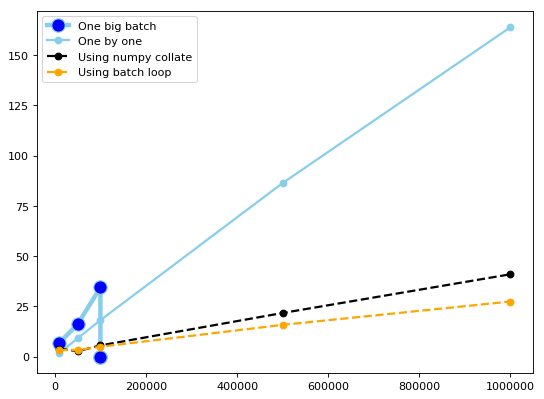

In [32]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot('bs', 'time', data=times_n_batch, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label="One big batch")
plt.plot('bs', 'time', data=times_n_single, marker='o', color='skyblue', linewidth=2, label="One by one")
plt.plot('bs', 'time', data=times_n_collate, marker='o', color='black', linewidth=2, linestyle='dashed', label="Using numpy collate")
plt.plot('bs', 'time', data=times_n_batch_loop, marker='o', color='orange', linewidth=2, linestyle='dashed', label="Using batch loop")
plt.legend()

In [9]:
"""
valid_ids = load_pickle(valid_id_file)
sample10k = valid_ids.sample(10000)
sample50k = valid_ids.sample(50000)
sample100k = valid_ids.sample(100000)
sample500k = valid_ids.sample(500000)
sample1M = valid_ids.sample(1000000)
dump_to_pickle(training_dir + "sample_indices/sample10k.pkl", sample10k)
dump_to_pickle(training_dir + "sample_indices/sample50k.pkl", sample50k)
dump_to_pickle(training_dir + "sample_indices/sample100k.pkl", sample100k)
dump_to_pickle(training_dir + "sample_indices/sample500k.pkl", sample500k)
dump_to_pickle(training_dir + "sample_indices/sample1M.pkl", sample1M)
"""

In [38]:
ds = CaddDataset(lmdb_dir, ids_10k_file)
df = ds.load_all_with_metadata()


100%|██████████| 156/156 [00:59<00:00,  2.61it/s]

In [39]:
df

{'inputs': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float16),
 'targets': array([0., 0., 0., ..., 0., 0., 0.]),
 'metadata': {'variant_id': array(["5:171125664:A:['G']", "7:153470120:N:['N']",
         "2:203575895:A:['G']", ..., "10:91069765:G:['A']",
         "4:140409513:G:['A']", "4:190445229:N:['N']"], dtype='<U20')}}